# Algorithmic Trading Strategy Challenge

Name: Hrishi Mehta 

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Strategy Implementation

[*********************100%%**********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Final Balance: $200371.27
Total Return: 0.95%
Annualized Return: 1.05%
Volatility: 0.21%
Sharpe Ratio: 3.02
Max Drawdown: -0.16%
Price: $161.50999450683594     | Shares: 12   | Action: Buy  | Date: 2022-08-02 00:00:00
Price: $160.00999450683594     | Shares: -12  | Action: Sell | Date: 2022-08-03 00:00:00
Price: $166.1300048828125      | Shares: 12   | Action: Buy  | Date: 2022-08-04 00:00:00
Price: $165.80999755859375     | Shares: -12  | Action: Sell | Date: 2022-08-05 00:00:00
Price: $165.35000610351562     | Shares: 12   | Action: Buy  | Date: 2022-08-08 00:00:00
Price: $164.8699951171875      | Shares: -12  | Action: Sell | Date: 2022-08-09 00:00:00
Price: $164.9199981689453      | Shares: 12   | Action: Buy  | Date: 2022-08-10 00:00:00
Price: $169.24000549316406     | Shares: 0    | Action: No action | Date: 2022-08-11 00:00:00
Price: $168.49000549316406     | Shares: -12  | Action: Sell | Date: 2022-08-12 00:00:00
Price: $172.10000610351562     | Shares: 11   | Action: Buy  | D

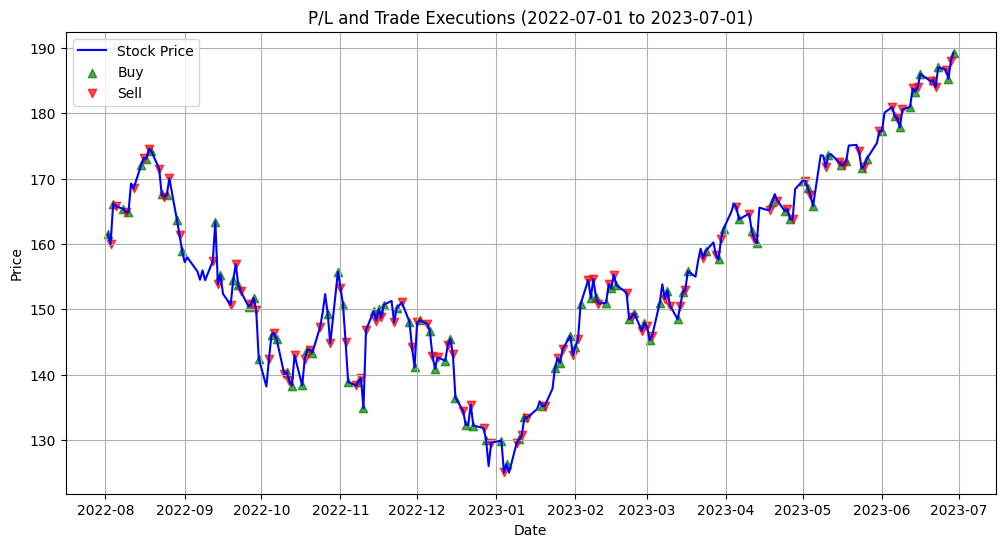

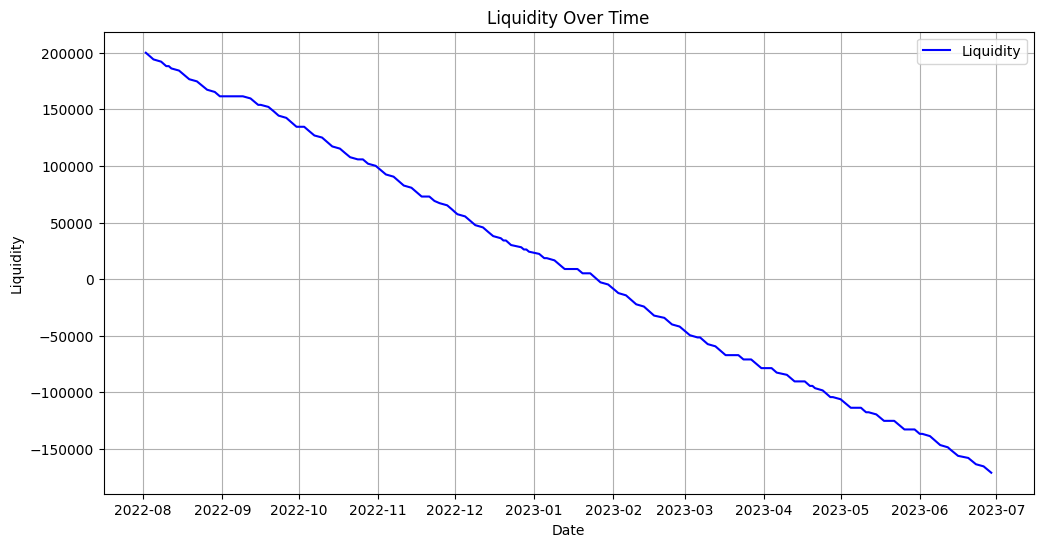

[*********************100%%**********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


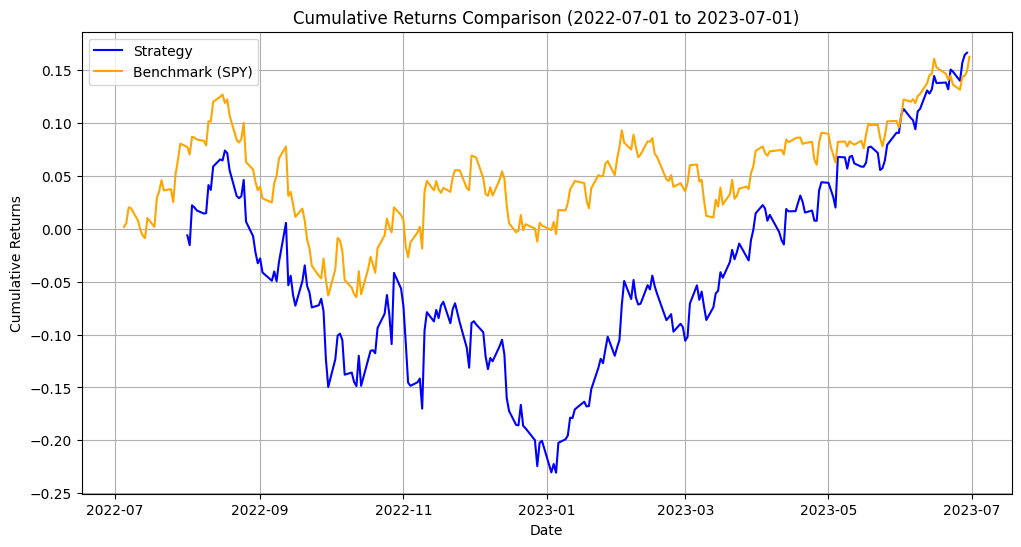

In [14]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import pandas as pd

# Risk-free rate functions
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate():
    annualized = yf.download("^IRX")["Adj Close"]
    daily = annualized.apply(deannualize)
    return pd.DataFrame({"annualized": annualized, "daily": daily})

# Main strategy class
class NeuralNetworkStrategy:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model = MLPRegressor(
            hidden_layer_sizes=(100, 100, 100),
            max_iter=3000,
            random_state=42,
            alpha=0.0001
        )
        self.scaler = StandardScaler()
        self.data = None
        self.balance = 200000
        self.shares_held = 0
        self.signals = []
        self.positions = []
        self.trade_info = []
        self.invested_capital = 0
        self.final_balance = 0
        self.total_return = 0
        self.annualized_return = 0
        self.volatility = 0
        self.sharpe_ratio = 0
        self.max_drawdown = 0
        self.risk_free_rate = get_risk_free_rate()

    def download_data(self):
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

    def calculate_rsi(self, prices, window=14):
        difference = prices.diff(1)
        gain = difference.where(difference > 0, 0)
        loss = -difference.where(difference < 0, 0)
        average_gain = gain.rolling(window=window, min_periods=1).mean()
        average_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = average_gain / average_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_atr(self, high, low, closing, window=14):
        one = high - low
        two = abs(high - closing.shift(1))
        three = abs(low - closing.shift(1))
        range_value = pd.concat([one, two, three], axis=1).max(axis=1)
        atr = range_value.rolling(window=window).mean()
        return atr

    def calculate_macd(self, prices, fast_period=12, slow_period=26, signal_period=9):
        fast_ema = prices.ewm(span=fast_period, adjust=False).mean()
        slow_ema = prices.ewm(span=slow_period, adjust=False).mean()
        macd = fast_ema - slow_ema
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        return macd, signal

    def calculate_stochastic_oscillator(self, high, low, closing, window=14):
        lowest_low = low.rolling(window=window).min()
        highest_high = high.rolling(window=window).max()
        k_percent = 100 * ((closing - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=3).mean()
        return k_percent, d_percent

    def prepare_data(self):
        self.data['Returns'] = self.data['Close'].pct_change()
        self.data['RSI'] = self.calculate_rsi(self.data['Close'])
        self.data['ATR'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'])
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean()
        self.data['Upper_BollingerBand'] = self.data['SMA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['Lower_BollingerBand'] = self.data['SMA'] - 2 * self.data['Close'].rolling(window=20).std()
        self.data['MACD'], self.data['MACD_Signal'] = self.calculate_macd(self.data['Close'])
        self.data['Stochastic_%K'], self.data['Stochastic_%D'] = self.calculate_stochastic_oscillator(self.data['High'], self.data['Low'], self.data['Close'])
        
        self.data = self.data.shift(1)
        self.data['Returns'] = self.data['Returns'].shift(-1)
        self.data.dropna(inplace=True)

        feature_matrix = self.data[['Returns', 'RSI', 'ATR', 'SMA', 'Upper_BollingerBand', 'Lower_BollingerBand', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D']].values
        target_variable = self.data['Returns'].values

        feature_train, feature_test, target_train, target_test = train_test_split(feature_matrix, target_variable, test_size=0.2, shuffle=False)
        feature_train = self.scaler.fit_transform(feature_train)
        feature_test = self.scaler.transform(feature_test)
        return feature_train, feature_test, target_train, target_test

    def tune_hyperparameters(self, feature_train, target_train):
        architectures = [(100, 100), (200, 200), (100, 100, 100)]
        best_mse = float('inf')
        best_model = None
        for architecture in architectures:
            model = MLPRegressor(hidden_layer_sizes=architecture, max_iter=3000, random_state=42, alpha=0.0001)
            model.fit(feature_train, target_train)

            y_pred = model.predict(feature_train)
            mse = mean_squared_error(target_train, y_pred)

            if mse < best_mse:
                best_mse = mse
                best_model = model
        self.model = best_model

    def generate_signals(self, X):
        predictions = self.model.predict(X)
        signals = [0]
        portfolio_value = [self.balance]
        take_profit_threshold = 0.01

        for i in range(1, len(X)):
            price = self.data['Close'].iloc[i]
            predicted_price = price + predictions[i]
            risk_percentage = 0.01
            current_date = self.data.index[i]

            if self.shares_held == 0 and predictions[i] > 0:
                max_shares = int(self.balance * risk_percentage / price)
                shares_to_buy = min(max_shares, int(self.balance / price))
                if shares_to_buy > 0:
                    self.balance -= shares_to_buy * price
                    self.shares_held += shares_to_buy
                    self.invested_capital += shares_to_buy * price
                    self.trade_info.append((price, shares_to_buy, "Buy", current_date))
            elif self.shares_held > 0 and (predictions[i] <= 0 or predicted_price >= price * (1 + take_profit_threshold)):
                self.balance += self.shares_held * price
                self.trade_info.append((price, -self.shares_held, "Sell", current_date))
                self.shares_held = 0
            else:
                self.trade_info.append((price, 0, "No action", current_date))

            portfolio_value.append(self.balance + self.shares_held * price)
            signals.append(predictions[i])
        return signals, portfolio_value

    def implement_strategy(self):
        X_data = self.data[['Returns', 'RSI', 'ATR', 'SMA', 'Upper_BollingerBand', 'Lower_BollingerBand', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D']].values
        self.signals, portfolio_value = self.generate_signals(X_data)
        self.positions = portfolio_value

    def run(self):
        self.download_data()
        feature_train, feature_test, target_train, target_test = self.prepare_data()
        self.tune_hyperparameters(feature_train, target_train)
        self.implement_strategy()
        self.calculate_metrics()
        self.print_metrics()

    def get_trade_info(self):
        return self.trade_info

    def calculate_metrics(self):
        self.data['Portfolio Value'] = self.positions
        self.data['Daily Returns'] = self.data['Portfolio Value'].pct_change()

        self.final_balance = self.positions[-1]
        self.total_return = (self.final_balance / self.balance) - 1
        self.annualized_return = ((1 + self.total_return) ** (252 / len(self.data))) - 1

        self.volatility = self.data['Daily Returns'].std() * np.sqrt(252)
        risk_free_rate = self.risk_free_rate['daily'].mean() if not self.risk_free_rate.empty else 0
        self.sharpe_ratio = (self.annualized_return - risk_free_rate) / self.volatility

        self.max_drawdown = self.calculate_max_drawdown()

    def calculate_max_drawdown(self):
        roll_max = self.data['Portfolio Value'].cummax()
        drawdown = self.data['Portfolio Value'] / roll_max - 1
        return drawdown.min()

    def print_metrics(self):
        print(f"Final Balance: ${self.final_balance:.2f}")
        print(f"Total Return: {self.total_return:.2%}")
        print(f"Annualized Return: {self.annualized_return:.2%}")
        print(f"Volatility: {self.volatility:.2%}")
        print(f"Sharpe Ratio: {self.sharpe_ratio:.2f}")
        print(f"Max Drawdown: {self.max_drawdown:.2%}")

# Example usage with a single ticker:
if __name__ == '__main__':
    ticker = 'AAPL'
    start_date = '2022-07-01'
    end_date = '2023-07-01'
    strategy = NeuralNetworkStrategy(ticker, start_date, end_date)
    strategy.run()
    trade_info = strategy.get_trade_info()

    for info in trade_info:
        price = f"Price: ${info[0]}".ljust(30)
        shares = f"Shares: {info[1]}".ljust(12)
        action = f"Action: {info[2]}".ljust(12)
        date = f"Date: {info[3]}"
        print(price + " | " + shares + " | " + action + " | " + date)

# Plot Profit/Loss
def plot_profit_loss(trade_info, start_date, end_date):
    prices = [info[0] for info in trade_info]
    shares = [info[1] for info in trade_info]
    actions = [info[2] for info in trade_info]
    trade_dates = [info[3] for info in trade_info]
    buy_dates = [trade_dates[i] for i in range(len(trade_dates)) if actions[i] == "Buy"]
    sell_dates = [trade_dates[i] for i in range(len(trade_dates)) if actions[i] == "Sell"]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, prices, label="Stock Price", color="blue")
    plt.scatter(buy_dates, [prices[trade_dates.index(date)] for date in buy_dates], label="Buy", marker="^", color="green", alpha=0.7)
    plt.scatter(sell_dates, [prices[trade_dates.index(date)] for date in sell_dates], label="Sell", marker="v", color="red", alpha=0.7)
    plt.title(f"P/L and Trade Executions ({start_date} to {end_date})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_profit_loss(trade_info, start_date, end_date)

# Plot Liquidity
def plot_liquidity(trade_info):
    dates = [trade[3] for trade in trade_info]
    liquidity = [200000]
    for i in range(1, len(trade_info)):
        action, shares, price = trade_info[i][2], trade_info[i][1], trade_info[i][0]
        if action == "Buy":
            liquidity.append(liquidity[-1] - (shares * price))
        elif action == "Sell":
            liquidity.append(liquidity[-1] + (shares * price))
        else:
            liquidity.append(liquidity[-1])
    plt.figure(figsize=(12, 6))
    plt.plot(dates, liquidity, label="Liquidity", color="blue")
    plt.title("Liquidity Over Time")
    plt.xlabel("Date")
    plt.ylabel("Liquidity")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_liquidity(trade_info)

# Benchmark Comparison
def compare_against_benchmark(strategy_data, benchmark_ticker='SPY', start_date='2022-07-01', end_date='2023-07-01'):
    benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)
    benchmark_data['Returns'] = benchmark_data['Close'].pct_change()
    strategy_data['Cumulative_Returns'] = (1 + strategy_data['Returns']).cumprod() - 1
    benchmark_data['Cumulative_Returns'] = (1 + benchmark_data['Returns']).cumprod() - 1

    plt.figure(figsize=(12, 6))
    plt.plot(strategy_data.index, strategy_data['Cumulative_Returns'], label='Strategy', color='blue')
    plt.plot(benchmark_data.index, benchmark_data['Cumulative_Returns'], label='Benchmark (SPY)', color='orange')
    plt.title(f"Cumulative Returns Comparison ({start_date} to {end_date})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_against_benchmark(strategy.data)
